<a href="https://colab.research.google.com/github/danhph/CS2225.CH1501.Face-Mask-Detection/blob/master/FaceMaskDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection and Preprocessing

## Load dataset

From Kaggle - Face Mask ~12K Images Dataset 
https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Datasets/Face\ Mask\ Dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Datasets/Face Mask Dataset


## Install Face Detection library

In [2]:
!pip install fdet==0.2.1

## Import libraries

In [3]:
import cv2
import tensorflow as tf
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from fdet import io, MTCNN, RetinaFace
from sklearn.metrics import classification_report
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from IPython.display import HTML

## Set Constants

In [4]:
batch_size = 32
epoch = 2
num_classes = 2
step_per_epoch = len(glob('Train/*/*')) // batch_size

image_h, image_w = 128, 128
classes = sorted(['WithMask','WithoutMask'])

## Reading Images
- Input image was resized to (128,128) for (height, width) and values in the image tensor were scaled to the range of (-1,1).
- Entire dataset was split into training and test set for cross validation. Split ratio was chose such that 90 percent of the dataset is part of the training set and 10 percent for test set.

In [5]:
def read_img(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_image(img, channels=3)
  img.set_shape([None,None,3])
  img = tf.image.resize(img, [image_w, image_h])
  img  = img/127.5-1
  return img

label_map = {v:i for i, v in enumerate(classes)}

images = glob('Train/*/*')
np.random.shuffle(images)

labels = [label_map[x.split('/')[-2]] for x in images]

(train_images, test_images, train_labels, test_labels) = train_test_split(images, labels,
	test_size=0.10, stratify=labels, random_state=42)

#reading image and label
def load_data(image_path, label):
  image = read_img(image_path)
  return image, label

Data Generator

In [6]:
def data_generator(features,labels):
  dataset = tf.data.Dataset.from_tensor_slices((features,labels))
  dataset = dataset.shuffle(buffer_size=100)
  autotune = tf.data.experimental.AUTOTUNE
  dataset = dataset.map(load_data, num_parallel_calls=autotune)
  dataset = dataset.batch(batch_size=batch_size)
  dataset = dataset.repeat()
  dataset = dataset.prefetch(autotune)
  return dataset

## Visualization of Classification Training Data

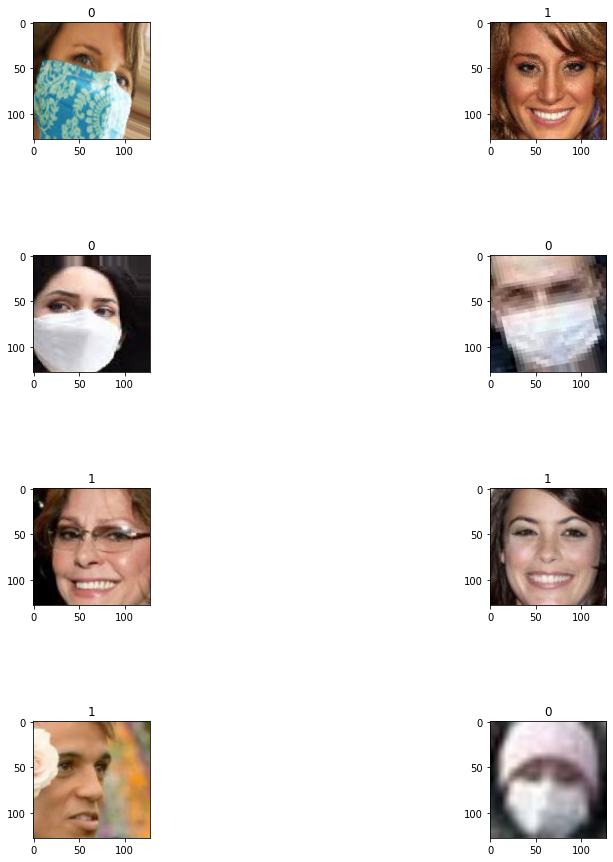

In [7]:
def show_img(dataset):
  plt.figure(figsize=(15,15))
  for i in range(8):
    for val in dataset.take(1):
      img  = (val[0][i]+1)*127.5
      plt.subplot(4,2,i+1)
      plt.imshow(tf.cast(img,tf.uint8))
      plt.title(val[1][i].numpy())
      plt.subplots_adjust(hspace=1)
  plt.show()

train_dataset = data_generator(train_images,train_labels)

show_img(train_dataset)

# Use Proposed model for Face Mask Detection

***Face Mask Detection*** = *Face Detection* + **Face Mask Classification**


## Model for Classification: Xception

In [8]:
base_model = tf.keras.applications.Xception(include_top=False,
                                       input_shape=(None, None, 3),
                                       weights='imagenet')
base_model.trainable = False
layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
layer = tf.keras.layers.Dense(1024, activation='relu')(layer)
layer = tf.keras.layers.Dropout(0.5)(layer)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(layer)
model = tf.keras.models.Model(base_model.inputs,output)
model.summary()

83689472/83683744 [==============================] - 0s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________

### Model fitting

Implementation details for classification architecture:
- ***Batch Size***: 32 <br>

- ***Epochs***: 2 <br>

- ***Learning rate***: 1e-4 (with decay of 1e-4 / epoch)<br>

- ***Gradient Descent Optimizer***: Adam<br>

- ***Loss function***: Sparse categorical cross entropy<br>

- ***Criterion for evaluation*** (metric): F1-score<br>

In [9]:
#We can use learning rate scheduler here like Cyclical Learning Rate(available in Tf Addons)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4, decay=1e-4 / epoch),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('mask_classification_model.h5', 
                                       save_best_only=True, 
                                       save_weights_only=True,
                                       monitor='loss')]

model.fit(train_dataset,
          batch_size=batch_size,
          epochs=epoch,steps_per_epoch=step_per_epoch,
          callbacks=callbacks)

Epoch 1/2
312/312 [==============================] - 660s 2s/step - loss: 0.0384 - accuracy: 0.9856
Epoch 2/2
312/312 [==============================] - 660s 2s/step - loss: 0.0102 - accuracy: 0.9968


### Testing the classification model

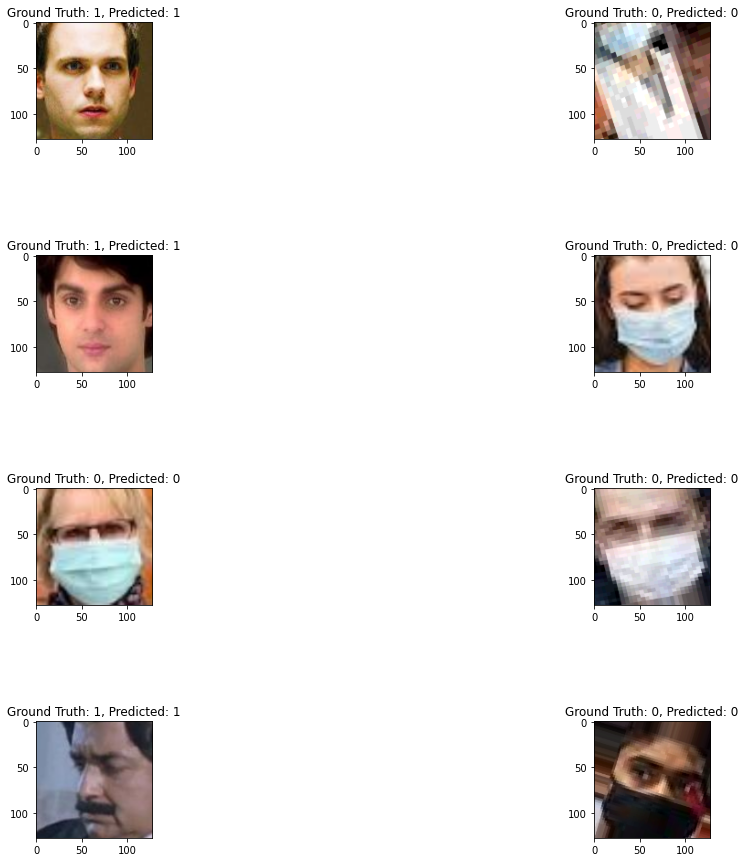

In [10]:
plt.figure(figsize=(15,15))
for i in range(8):
  for val in train_dataset.take(1):
    plt.subplot(4,2,i+1)
    img  = (val[0][i]+1)*127.5
    plt.imshow(tf.cast(img,tf.uint8))
    y_pred = model.predict(np.expand_dims(val[0][i],axis=0))
    y_pred = np.argmax(y_pred,axis=1)
    plt.title('Ground Truth: {}, Predicted: {}'.format(val[1][i],y_pred[0]))
    plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

### Evaluation

In [11]:
pred_labels = []
for image_path in (test_images):
  image = read_img(image_path)
  y_pred = model.predict(np.expand_dims(image,axis=0))
  y_pred = np.argmax(y_pred,axis=1)
  pred_labels.append(y_pred)

print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       500
           1       1.00      0.99      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



## Model for Detection: RetinaNet Face

### Visualize methods

In [12]:
def visualize_detections(image, boxes):
  
  figsize=(7, 7)
  linewidth=1

  image = np.array(image, dtype=np.uint8)

  plt.figure(figsize=figsize)
  plt.axis('off')
  plt.imshow(image)

  ax = plt.gca()

  for box in boxes:
    x, y, w, h = box
  
    face_image = image[y:y+h,x:x+w]
    
    #To handle those cases where the  height and width of the generated cropped face become 0
    if face_image.shape[0] and face_image.shape[1]:

      face_image = tf.image.resize(face_image, [image_w, image_h])
      face_image = face_image/127.5-1

      _cls = model.predict(np.expand_dims(face_image,axis=0))
      _cls = np.argmax(_cls,axis=1)
      
      text = '{}'.format(class_map[_cls[0]])

      patch = plt.Rectangle([x, y], w, h, fill=False, 
                            edgecolor=color_map_image[_cls[0]], linewidth=linewidth)
      ax.add_patch(patch)
      ax.text(x, y, text, bbox={'facecolor':color_map_image[_cls[0]], 'alpha':0.2}, 
          clip_box=ax.clipbox, clip_on=True)
  

def visualize_detections_video(image, boxes):
  
  image = np.array(image, dtype=np.uint8)
  
  for box in boxes:
    x, y, w, h = box    
    face_image = image[y:y+h,x:x+w] 
    if w<90 or h<90:
      w = (w*0.5)+w
      h = (h*0.5)+h

    #To handle those cases where the  height and width of the generated cropped face become 0
    if face_image.shape[0] and face_image.shape[1]:
      face_image = tf.image.resize(face_image, [image_w, image_h])
      face_image = face_image/127.5-1
      
      _cls = model.predict(np.expand_dims(face_image,axis=0))
      _cls = np.argmax(_cls,axis=1)

      text = '{}'.format(class_map[_cls[0]])    
      start = tuple(np.array((x,y)).astype('int'))
      end = tuple(np.array((x+w,y+h)).astype('int'))
      
      cv2.rectangle(image,start,end,color_map_video[_cls[0]],1)
      cv2.putText(image, class_map[_cls[0]], start , cv2.FONT_HERSHEY_SIMPLEX, 0.4, color_map_video[_cls[0]], 1)
  return (image)  


### Test on images

In [14]:
 import numpy as np
 import urllib.request as urllib
 import cv2

 #get image by url
 resp = urllib.urlopen("https://images.unsplash.com/photo-1594397856557-75aca2e35b00?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&dl=amish-thakkar-dHQf0wGQTzk-unsplash.jpg")
 image = np.asarray(bytearray(resp.read()), dtype="uint8")
 image = cv2.imdecode(image, cv2.IMREAD_COLOR)

detector = RetinaFace(backbone='RESNET50')

# image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) 
result = detector.detect(image)

boxes = []
for i in range(len(result)):
  boxes.append(result[i]['box'])
boxes = np.array(boxes)

visualize_detections(image, boxes)

Downloading: "https://www.dropbox.com/s/d0xdha71fwr53uk/retinaface_resnet50_final.pt?dl=1" to /root/.cache/torch/hub/checkpoints/retinaface_resnet50_final.pt


HTTPError: ignored